In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zarinadossayeva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zarinadossayeva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zarinadossayeva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
csv_files = ['/Users/zarinadossayeva/Downloads/news_part1.csv'
           #  , '/path/to/your/second.csv', 
           #  '/path/to/your/third.csv', 
           #  '/path/to/your/fourth.csv'
            ]  # Replace with your file paths
dataframes = [pd.read_csv(f) for f in csv_files]
data = pd.concat(dataframes, ignore_index=True)

In [3]:
dataframes

[      Ticker                                              Title  \
 0       META  Ads running on Meta saw return on spending inc...   
 1       AAPL  Ads running on Meta saw return on spending inc...   
 2        HUM  Here are the reasons why a new Wall Street upg...   
 3       AAPL  Here are the reasons why a new Wall Street upg...   
 4        BAC  Here are the reasons why a new Wall Street upg...   
 ...      ...                                                ...   
 79492   CRWD  2 Cybersecurity Stocks You Can Buy and Hold fo...   
 79493   PATH  3 Supercharged Tech Stocks to Buy Without Any ...   
 79494   CRWD  3 Supercharged Tech Stocks to Buy Without Any ...   
 79495     DE                                     Weekly Roundup   
 79496   AAPL                                     Weekly Roundup   
 
                                                      URL       Time Published  \
 0      https://www.business-standard.com/companies/ne...  2024-01-18 17:28:08   
 1      https://ww

In [4]:
# Preprocess the text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', 'urlplaceholder', text)
    text = re.sub(r'\d+', 'numplaceholder', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [5]:
# Combine 'Title' and 'Summary' into a single text feature
data['Combined_Text'] = data['Title'] + " " + data['Summary']
data['Processed_Text'] = data['Combined_Text'].apply(preprocess_text)

In [6]:
# Encode the 'Ticker Sentiment Label'
label_encoder = LabelEncoder()
data['Sentiment_Label_Encoded'] = label_encoder.fit_transform(data['Ticker Sentiment Label'])
labels = to_categorical(data['Sentiment_Label_Encoded'])

In [7]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data['Processed_Text'], labels, test_size=0.2, random_state=42)

In [8]:
# Tokenize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [9]:
# Pad the sequences
max_seq_length = max([len(x) for x in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

In [10]:
# Build the LSTM model with an additional neural network layer
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_seq_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

In [11]:
# Compile the model

# Set a learning rate
learning_rate = 0.001  

# Create an optimizer with the desired learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
# Include the callback in the fit function
history = model.fit(
    X_train_pad, y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
1988/1988 [==============================] - 396s 198ms/step - loss: 0.8704 - accuracy: 0.6776 - val_loss: 0.7708 - val_accuracy: 0.6955
Epoch 2/5
1988/1988 [==============================] - 394s 198ms/step - loss: 0.7533 - accuracy: 0.7011 - val_loss: 0.7335 - val_accuracy: 0.7086
Epoch 3/5
1988/1988 [==============================] - 401s 202ms/step - loss: 0.7065 - accuracy: 0.7172 - val_loss: 0.7208 - val_accuracy: 0.7131
Epoch 4/5
1988/1988 [==============================] - 404s 203ms/step - loss: 0.6769 - accuracy: 0.7269 - val_loss: 0.7124 - val_accuracy: 0.7162
Epoch 5/5
1828/1988 [==========================>...] - ETA: 31s - loss: 0.6539 - accuracy: 0.7353

In [47]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

497/497 [==============================] - 12s 24ms/step - loss: 0.7771 - accuracy: 0.6972
Test accuracy: 69.72%


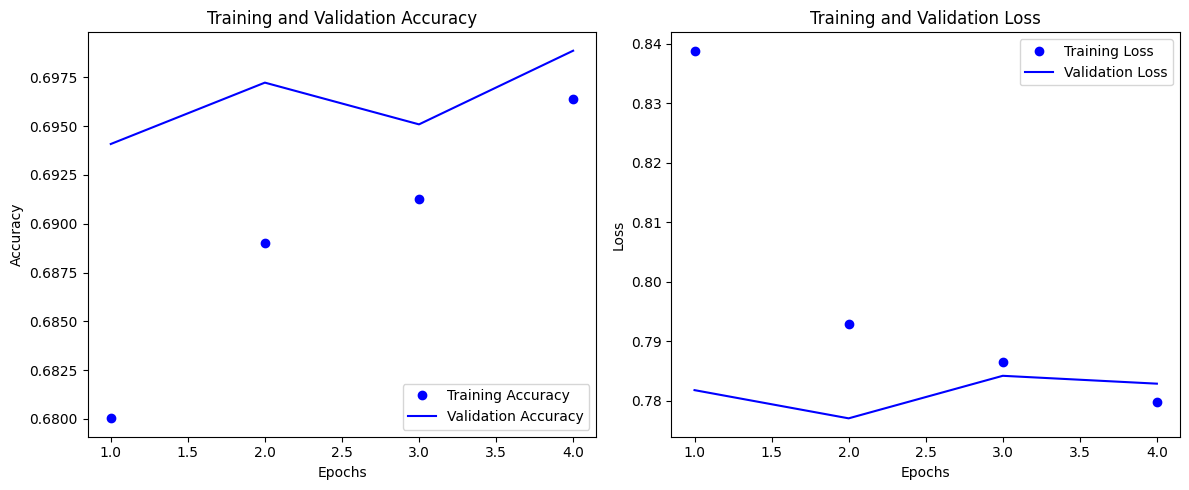

In [48]:
import matplotlib.pyplot as plt

# Extracting the history of training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()